In [325]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

### Тест пропорций. Выборки А и В содержат дискретные случайные величины. 

Выборки размеров n и m, с конверсией - a и b (число единиц или успехов).

Гипотезы.

H0: выбрки А и В из одного распределения
H1: выборки из разных распределений

In [326]:
def evaluate_pvals(a=70, b=48, n=700, m=300, N=1000):
    p = (a + b) / (n + m)
    pvals = []

    for _ in tqdm(range(N)):
        A = np.random.binomial(1, a / n, n)
        B = np.random.binomial(1, b / m, m)

        # фиксируем различие
        diff = abs(A.mean() - B.mean())

        # как часто различие будет равно и больше при многократном семплировании из выборки A+B
        pval = np.mean([abs(np.random.binomial(1, p, n).mean() - np.random.binomial(1, p, m).mean()) >= diff for _ in range(N)])
        pvals.append(pval) 
    
    return pvals

In [327]:
n = 700 # размер выборки А
m = 300 # размер выборки В

a = 70  # конверсия по выборке А
b = 48  # конверсия по выборке В

# количество экспериментов Монте-Карло
N = 1000

# многократно семплируя наблюдения (эксперимент Монте Карло) считаем число превышений заданной
# конверсии, это и есть p-value
pvals = evaluate_pvals(a, b, n, m, N)

Мощность теста (power) для порога значимости alpha.

In [328]:
alpha = 0.05 # порог значимости, ложные срабатывания, ошибка I рода
power = np.mean(np.array(pvals) < alpha)

print("Как часто будем отвергать Н0 при условии что она не верна.")
print("Мощность теста =", str(power))

Как часто будем отвергать Н0 при условии что она не верна.
Мощность теста = 0.739


In [329]:
def plot_the_couple(pvals, N, power, alpha):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

    axes[0].hist(pvals)
    axes[0].set_xlabel("p values")
    axes[0].set_xlim(-0.1, 1.1)

    
    np.array(pvals.sort())
    df = pd.DataFrame({"pvals": pvals, "TPR": [i / N for i in range(N)]})
    
    axes[1].plot(df["pvals"], df["TPR"], label="ROC")
    axes[1].plot([alpha, alpha], [0, 1], "k", label="alpha")
    axes[1].plot([0, alpha], [power, power], label="Power")
    axes[1].set_ylabel("TPR, recall, sencitivity, Power")
    axes[1].set_xlabel("FPR")
    axes[1].set_title("ROC")
    axes[1].set_xlim(-0.1, 1.1)
    axes[1].legend()
    plt.show()

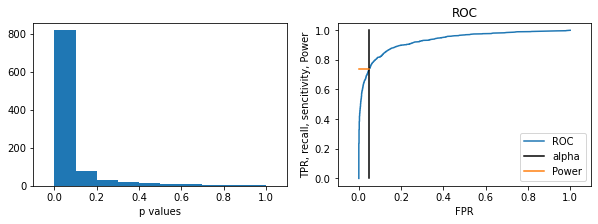

In [330]:
plot_the_couple(pvals, N, power, alpha)

Значение p values сконцентрировано у 0, значит выборки из разных распределений.

Полученная мощность теста ниже 0.80 (80%). Чтобы увеличить мощность теста необходимо увеличить размер выборок n и m.

## АА тест

Также нужно провести А/А тест (sanity test) для проверки применимости теста на имеющихся данных.

In [331]:
pvals = evaluate_pvals(a, a, n, n, N)

Доля ложных срабатываний - False Positive

In [332]:
alpha = 0.05
FP = np.mean(np.array(pvals) < alpha)
FP

0.054

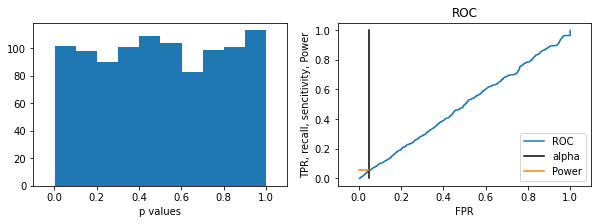

In [333]:
plot_the_couple(pvals, N, FP, alpha)

Распределение значения p value равномерно, а уровень False Positive на уровне alpha значит на данных можно применять статистические тесты.

## Тесты из библиотек

Применим несколько тетстов из библиотек чтобы проверить наши выводы, сделанные из эксперимента Монте Карло

In [334]:
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats

In [335]:
statistics, pvalue = proportions_ztest([a, b], [n, m])
print("p-value", pvalue)

p-value 0.007035346384355496


In [336]:
A = np.random.binomial(1, a / n, n)
B = np.random.binomial(1, b / m, m)

t-test

In [337]:
statistic, pvalue = scipy.stats.ttest_ind(A, B, equal_var=False)
print("p-value", pvalue)

p-value 0.1772737427831503


Mann-Whitneyu test

In [338]:
statistic, pvalue = scipy.stats.mannwhitneyu(A, B, alternative="two-sided")
print("p-value", pvalue)

p-value 0.15829355552529


Вывод: p-value ниже порога значимости alpha (0.05) а значит различие в конверсиях выборок A и B не случайно. Хотя мощность тестов не 100% поэтому мы можем и ошибаться.

## Lambda функция

Многократное семплирование можно задать заранее, а затем через lambda функцию посчитать значения p-value.

In [339]:
A = np.random.binomial(1, a / n, n * N).reshape(N, n)
B = np.random.binomial(1, b / m, m * N).reshape(N, m)

In [340]:
tt_pvalues = list(map(lambda x: scipy.stats.ttest_ind(x[0], x[1]).pvalue, zip(A, B)))
mw_pvalues = list(map(lambda x: scipy.stats.mannwhitneyu(x[0], x[1]).pvalue, zip(A, B)))

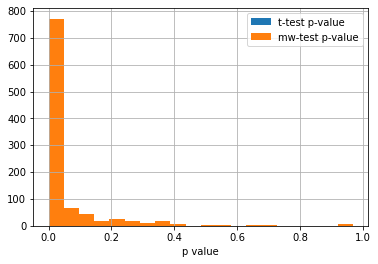

In [341]:
# распределение значения p
pd.Series(tt_pvalues).hist(label="t-test p-value", bins=20)
pd.Series(mw_pvalues).hist(label="mw-test p-value", bins=20)
plt.legend()
plt.xlabel("p value")
plt.show()

In [342]:
# мощности тестов
np.mean(np.array(tt_pvalues) < alpha), np.mean(np.array(mw_pvalues) < alpha)

(0.771, 0.771)

## Bootstrap

Давайте применим bootstrap для теста пропорций с определением мощности и построением ROC кривой.

In [343]:
def t_star(A, B):   
    C = np.hstack((A, B))
    
    A = pd.Series(C).sample(N, replace=True)
    B = pd.Series(C).sample(N, replace=True)
    
    # статистика теста
    t = (A.mean() - B.mean()) / np.sqrt(A.var()/len(A) + B.var()/len(B))
    return t

In [39]:
pvals = []

for _ in tqdm(range(N)):
    A = np.random.binomial(1, a / n, n)
    B = np.random.binomial(1, b / m, m)

    # статистика теста
    t = (A.mean() - B.mean()) / np.sqrt(A.var() / len(A) + B.var() / len(B))
    
    # weighted bootstrap
    A = np.hstack((A, np.random.standard_t(len(A) - 1, len(A)) + A.mean()))
    B = np.hstack((B, np.random.standard_t(len(B) - 1, len(B)) + B.mean()))
    
    Z = np.hstack((A, B)).mean()
    
    A = A - A.mean() + Z
    B = B - B.mean() + Z    
    
    pval = np.mean([t_star(A, B) <= t for _ in range(100)])
    pvals.append(pval)

In [40]:
alpha = 0.05 # порог значимости, ложные срабатывания, ошибка I рода
power = np.mean(np.array(pvals) < alpha)

print("Как часто будем отвергать Н0 при условии что она не верна.")
print("Мощность теста =", str(power))

Как часто будем отвергать Н0 при условии что она не верна.
Мощность теста = 0.817


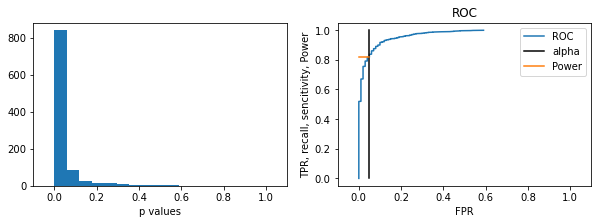

In [41]:
plot_the_couple(pvals, N, power, alpha)

## Bucketing

Есть еще один способ - группировка (bucketing). Но для него нужно много данных, т.к. он не семплирует выборки а бьёт их.

In [51]:
buckets = N
pvals = []

A = np.random.binomial(1, (a * N) / (n * N), n * N)
B = np.random.binomial(1, (b * N) / (m * N), m * N)

for bucket in np.arange(buckets):
    ind_A = np.arange(bucket * (n * N) / buckets, bucket * (n * N) / buckets + (n * N) / buckets).astype(np.int)
    ind_B = np.arange(bucket * (m * N) / buckets, bucket * (m * N) / buckets + (m * N) / buckets).astype(np.int)
    pvals.append(scipy.stats.ttest_ind(A[ind_A], B[ind_B]).pvalue)

In [52]:
alpha = 0.05 # порог значимости, ложные срабатывания, ошибка I рода
power = np.mean(np.array(pvals) < alpha)

print("Как часто будем отвергать Н0 при условии что она не верна.")
print("Мощность теста =", str(power))

Как часто будем отвергать Н0 при условии что она не верна.
Мощность теста = 0.743


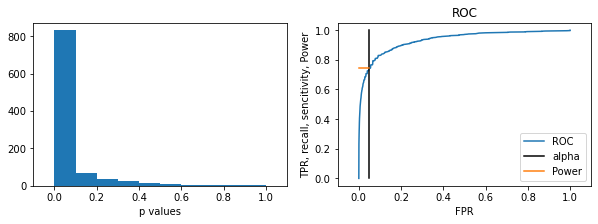

In [53]:
plot_the_couple(pvals, N, power, alpha)

## Линейная регрессия

Попробуем линейную регрессию.

In [319]:
class LinearRegression(object):
    def __init__(self):
        self.weights = None
    
    def fit(self, dataset):
        X, y = dataset
        
        X = X[:, np.newaxis]
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        self.weights = np.ones(X.shape[1])
        
        for _ in range(100):
            predict = X.dot(self.weights)
            error = predict - y
            dw = 1 / len(y) * X.T.dot(error)
            self.weights -= 0.1 * dw
        
        return self.weights

In [320]:
def dataset():
    A = np.random.binomial(1, a / n, n)
    B = np.random.binomial(1, b / m, m)

    df_a = pd.DataFrame({"y": A, "group": [0] * len(A)})
    df_b = pd.DataFrame({"y": B, "group": [1] * len(B)})

    df = pd.concat([df_a, df_b])

    X, y = np.array(df["group"]), np.array(df["y"])
    
    return (X, y)

def dataset_AB():
    p = (a + b) / (n + m)
    A = np.random.binomial(1, p, n)
    B = np.random.binomial(1, p, m)

    df_a = pd.DataFrame({"y": A, "group": [0] * len(A)})
    df_b = pd.DataFrame({"y": B, "group": [1] * len(B)})

    df = pd.concat([df_a, df_b])

    X, y = np.array(df["group"]), np.array(df["y"])
    
    return (X, y)

In [321]:
n = 700 # размер выборки А
m = 300 # размер выборки В

a = 70  # конверсия по выборке А
b = 48  # конверсия по выборке В

# количество экспериментов Монте-Карло
N = 100

In [322]:
pvals = []

for _ in tqdm(range(N)):   
    k = LinearRegression().fit(dataset())[1]
    
    pval = np.mean([LinearRegression().fit(dataset_AB())[1] >= k for _ in range(1000)])
    pvals.append(pval)

In [323]:
alpha = 0.05 # порог значимости, ложные срабатывания, ошибка I рода
power = np.mean(np.array(pvals) < alpha)

print("Как часто будем отвергать Н0 при условии что она не верна.")
print("Мощность теста =", str(power))

Как часто будем отвергать Н0 при условии что она не верна.
Мощность теста = 0.79


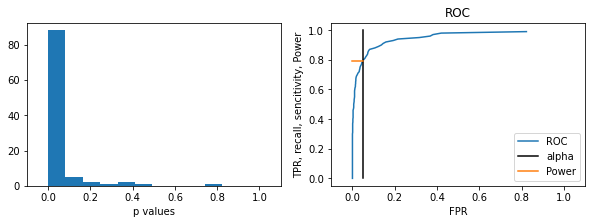

In [324]:
plot_the_couple(pvals, N, power, alpha)

## Перебор - permutation